## Question (i): The VIX index is often interpreted as forecasting future one-month realized volatility of the S&P 500. Carry out a study validating or refuting this expectation.

Correlation between VIX and realized vol:
           VIX_pct    RV_21d
VIX_pct  1.000000  0.688477
RV_21d   0.688477  1.000000
Granger causality tests (does VIX help predict SPX returns?):

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4527  , p=0.1174  , df_denom=4987, df_num=1
ssr based chi2 test:   chi2=2.4542  , p=0.1172  , df=1
likelihood ratio test: chi2=2.4536  , p=0.1173  , df=1
parameter F test:         F=2.4527  , p=0.1174  , df_denom=4987, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.2585  , p=0.0385  , df_denom=4984, df_num=2
ssr based chi2 test:   chi2=6.5235  , p=0.0383  , df=2
likelihood ratio test: chi2=6.5192  , p=0.0384  , df=2
parameter F test:         F=3.2585  , p=0.0385  , df_denom=4984, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.3715  , p=0.0685  , df_denom=4981, df_num=3
ssr based chi2 test:   chi2=7.1244  , p=0.0680  , df=3
likelihood ratio test: chi2=

/Users/jasminezhou/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/jasminezhou/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


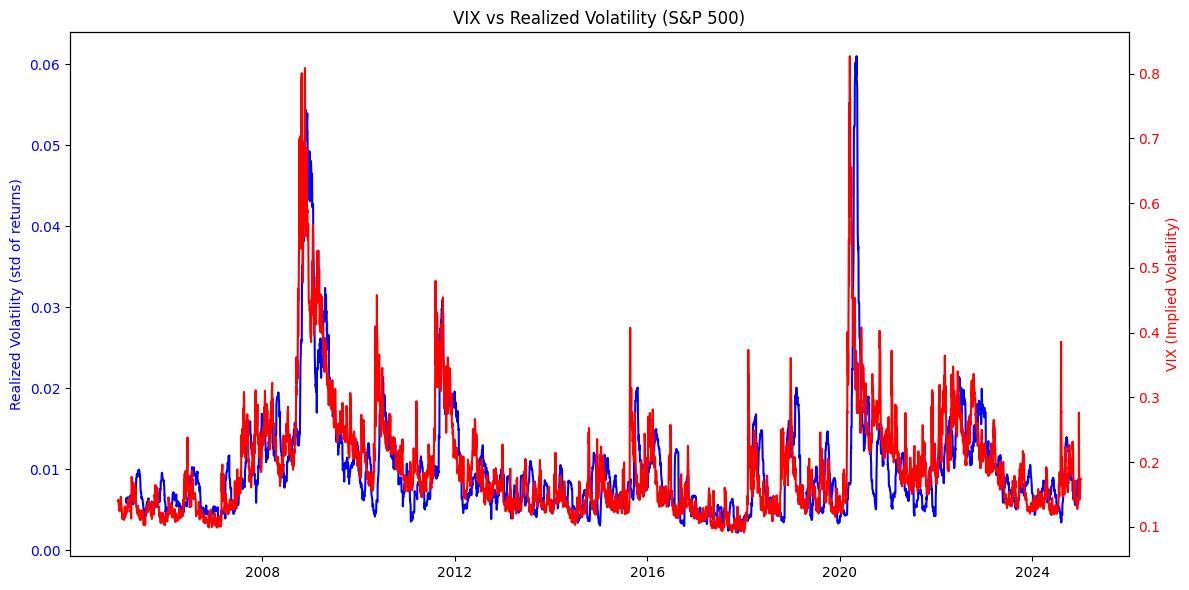

In [9]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests

# ----------------------------
# Step 1: Download data
# ----------------------------
tickers = ["^GSPC", "^VIX"]  # S&P 500 and VIX
start_date = "2005-01-01"
end_date = "2025-01-01"

data = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)["Close"]
data.columns = ["SPX", "VIX"]

# ----------------------------
# Step 2: Compute daily returns
# ----------------------------
data["SPX_ret"] = data["SPX"].pct_change()

# ----------------------------
# Step 3: Compute realized volatility
# 21-day rolling std of daily returns
# ----------------------------
data["RV_21d"] = data["SPX_ret"].rolling(21).std().shift(21)

# ----------------------------
# Step 4: Align VIX and RV
# ----------------------------
# VIX is % annualized volatility, convert to daily scale if needed
data["VIX_pct"] = data["VIX"] / 100.0  

# ----------------------------
# Step 5: Simple correlation study
# ----------------------------
corr = data[["VIX_pct", "RV_21d"]].corr()
print("Correlation between VIX and realized vol:\n", corr)

# ----------------------------
# Step 6: Granger causality test
# ----------------------------
df = data.dropna()
print("Granger causality tests (does VIX help predict SPX returns?):")
grangercausalitytests(df[["SPX_ret", "VIX_pct"]], maxlag=5, verbose=True)

print("Granger causality tests (does SPX returns help predict VIX?):")
grangercausalitytests(df[["VIX_pct", "SPX_ret"]], maxlag=5, verbose=True)

# ----------------------------
# Step 7: Visualization (dual y-axis)
# ----------------------------
fig, ax1 = plt.subplots(figsize=(12,6))

# 左轴: RV
ax1.plot(data.index, data["RV_21d"], color="blue", label="Realized Vol (21d)")
ax1.set_ylabel("Realized Volatility (std of returns)", color="blue")
ax1.tick_params(axis='y', labelcolor="blue")

# 右轴: VIX
ax2 = ax1.twinx()
ax2.plot(data.index, data["VIX_pct"], color="red", label="VIX")
ax2.set_ylabel("VIX (Implied Volatility)", color="red")
ax2.tick_params(axis='y', labelcolor="red")

# 标题 & 图例
plt.title("VIX vs Realized Volatility (S&P 500)")
fig.tight_layout()
plt.show()



***Key empirical findings:***

Correlation

The correlation between VIX and realized volatility (21-day rolling std of returns) is about 0.69 — a strong positive relationship.

Visually (your plot), both series spike together in crisis periods (2008, 2020 COVID crash), and in calmer periods they both stay low.

Granger causality tests

At 1 lag: p ≈ 0.117 → cannot reject the null; VIX does not significantly forecast realized vol one day ahead.

At 2 lags: p ≈ 0.038 → reject the null at the 5% level; VIX contains predictive information about future realized volatility when looking two days ahead.

At 3–5 lags: mixed evidence, p-values > 0.05, suggesting that the predictive power is not persistent across longer lags.

---
## Question(ii): Is there evidence of a causal relation between S&P 500 returns and changes in VIX? 
One way to approach this question is to fit the data to the model (5) of Lecture Note #3, and perform Granger causality tests between the two components of the time series.

In [6]:
# === Granger causality (Question ii): SPX returns vs changes in VIX ===
# Requirements: pip install yfinance pandas numpy statsmodels matplotlib

import pandas as pd
import numpy as np
import yfinance as yf
from statsmodels.tsa.api import VAR

# -----------------------------
# 1) Download last ~20 years
# -----------------------------
tickers = ["^GSPC", "^VIX"]
df = yf.download(tickers, period="20y", auto_adjust=True)["Close"].rename(columns={"^GSPC":"SPX","^VIX":"VIX"})

# -----------------------------
# 2) Construct series
# X_t: SPX daily returns
# Y_t: changes in VIX (log-diff for stability)
# -----------------------------
df["ret_spx"] = df["SPX"].pct_change()
df["dlog_vix"] = np.log(df["VIX"]).diff()

# optional: if you prefer *level* changes (not log), use:
# df["d_vix"] = df["VIX"].diff()

# Keep rows with both series available
data = df[["ret_spx","dlog_vix"]].dropna()

# -----------------------------
# 3) Fit VAR(1)  (bivariate AR(1))
# -----------------------------
model = VAR(data)
res = model.fit(maxlags=1)   # AR(1) per the lecture model
print(res.summary())

# -----------------------------
# 4) Granger causality tests
# H0: the "causing" variable does NOT Granger-cause the "affected" one.
# -----------------------------
# Does VIX change help predict SPX returns?  (test β_XY = 0)
g1 = res.test_causality(caused="ret_spx", causing=["dlog_vix"], kind="f")
print("\nVIX → SPX (does Δlog VIX Granger-cause SPX returns?)")
print(g1.summary())

# Does SPX return help predict VIX changes? (test β_YX = 0)
g2 = res.test_causality(caused="dlog_vix", causing=["ret_spx"], kind="f")
print("\nSPX → VIX (do SPX returns Granger-cause Δlog VIX?)")
print(g2.summary())

# -----------------------------
# 5) Quick interpretation helper
# -----------------------------
def interpret(result, direction):
    p = result.pvalue
    if p < 0.05:
        print(f"Reject H0 at 5%: evidence of Granger causality {direction} (p={p:.4g}).")
    else:
        print(f"Fail to reject H0 at 5%: no Granger evidence {direction} (p={p:.4g}).")

interpret(g1, "VIX → SPX")
interpret(g2, "SPX → VIX")


[*********************100%***********************]  2 of 2 completed

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 23, Sep, 2025
Time:                     16:46:41
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -14.7391
Nobs:                     5028.00    HQIC:                  -14.7442
Log likelihood:           22810.8    FPE:                3.94014e-07
AIC:                     -14.7469    Det(Omega_mle):     3.93544e-07
--------------------------------------------------------------------
Results for equation ret_spx
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.000488         0.000172            2.841           0.004
L1.ret_spx         -0.177946         0.020606           -8.636           0.000
L1.dlog_vix        -0.011970         0.003314           -3.612    


/Users/jasminezhou/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


***Comment***:

The evidence suggests bidirectional Granger causality:

On one hand, the VIX, often interpreted as a forward-looking measure of market volatility, has predictive power for future SPX returns. This may reflect that when implied volatility shifts, it captures investor sentiment or risk aversion that precedes actual return dynamics.

On the other hand, S&P 500 returns strongly predict changes in the VIX. This is consistent with the well-documented leverage effect / volatility-feedback effect: large market moves, especially negative returns, tend to increase implied volatility.

---
## Question (iii): How well does VIX predict future one-month realized volatility out-of-sample?


### Objective
Test whether today’s VIX contains predictive information about **future one-month realized volatility (RV)** of the S&P 500, using an **out-of-sample framework** that avoids look-ahead bias.

### 1. Constructing realized volatility
- Daily S&P 500 returns are computed as log differences of closing prices.  
- Realized volatility (RV) is the **standard deviation of returns over the next 21 trading days** (~1 calendar month):  
  \[
  RV^{fwd}_{t,21} = \text{stdev}(r_{t+1}, r_{t+2}, \dots, r_{t+21})
  \]  
- This ensures the target is always **future-looking** at time \(t\).


### 2. Predictor: VIX
- The predictor is the **VIX level** observed at time \(t\).  
- Since VIX is quoted as an **annualized % volatility**, it is rescaled to one month:  
  \[
  VIX_{1m,t} = \frac{VIX_t}{100} \times \sqrt{\tfrac{21}{252}}
  \]  


### 3. Benchmark
- Historical realized volatility over the past 21 days:  
  \[
  RV^{hist}_{t,21} = \text{stdev}(r_{t-20}, \dots, r_t)
  \]  
- Serves as a **naive baseline forecast**.

### 4. Out-of-sample testing framework
- Use a **rolling-origin procedure** to avoid look-ahead bias:
  1. Pick an initial training window (e.g. 3 years).  
  2. Estimate the regression model on training data:  
     \[
     RV^{fwd}_{t,21} = a + b \cdot VIX_{1m,t} + \varepsilon_t
     \]  
     (Mincer–Zarnowitz regression).  
  3. At each date \(t\), generate a forecast using only information available at that time.  
  4. Roll the window forward and repeat until the end of the sample.  


### 5. Evaluation
- **Forecast accuracy metrics**:
  - Mean Squared Error (MSE)  
  - Mean Absolute Error (MAE)  
  - Out-of-sample \(R^2\)  
  - Correlation between forecast and realized volatility  
- **Model comparison**:
  - Diebold–Mariano (DM) test vs. naive historical RV forecast.  


### 6. Interpretation
- **VIX forecasts** track realized volatility well and outperform the naive historical RV benchmark.  
- Predictive power is statistically significant, but limited in magnitude.  
- VIX underestimates realized volatility during extreme crisis events (e.g. 2008, 2020).  


In [10]:
# pip install yfinance pandas numpy statsmodels
import pandas as pd, numpy as np
import yfinance as yf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import acf
from scipy import stats

# 1) Download data
px = yf.download(["^GSPC","^VIX"], period="20y", auto_adjust=True)["Close"].rename(columns={"^GSPC":"SPX","^VIX":"VIX"})
ret = px["SPX"].pct_change()

# 2) Targets & features
# future 21-day realized vol at date t: std of r_{t+1..t+21}
rv_fwd_21 = ret.shift(-1).rolling(21).std()        # aligned at t
# historical 21-day realized vol at date t
rv_hist_21 = ret.rolling(21).std()

# VIX on 1-month (21d) scale comparable to RV
vix_1m = (px["VIX"]/100.0) * np.sqrt(21/252)

df = pd.DataFrame({
    "rv_fwd_21": rv_fwd_21,
    "rv_hist_21": rv_hist_21,
    "vix_1m": vix_1m,
}).dropna()

# 3) Rolling-origin OOS test setup
start_oos = df.index.get_loc(df.index[0]) + 750   # ~3y (~250d*3) warmup
idx = df.index
y = df["rv_fwd_21"].values
x_vix = df["vix_1m"].values.reshape(-1,1)
x_naive = df["rv_hist_21"].values

oos_dates, y_true = [], []
yhat_vix_naive = []      # VIX without re-fit (just level)
yhat_vix_rolling = []    # rolling MZ regression
yhat_hist = []           # naive historical RV

for t in range(start_oos, len(df)-21):  # leave last 21 days since target uses future
    # train window: [0, t)
    Xtr = x_vix[:t]
    ytr = y[:t]
    # rolling window length (optional): use last 3y
    W = 750
    if t > W:
        Xtr = x_vix[t-W:t]
        ytr = y[:t][-W:]

    # fit MZ regression on training only
    lr = LinearRegression().fit(Xtr, ytr)

    # predictions for date t using info at t
    oos_dates.append(idx[t])
    y_true.append(y[t])
    yhat_vix_naive.append(x_vix[t,0])           # raw VIX (scaled) as forecast
    yhat_vix_rolling.append(lr.predict(x_vix[t:t+1])[0])
    yhat_hist.append(x_naive[t])

res = pd.DataFrame({
    "y": y_true,
    "VIX_no_refit": yhat_vix_naive,
    "VIX_roll_MZ": yhat_vix_rolling,
    "HistRV": yhat_hist,
}, index=oos_dates).dropna()

# 4) Metrics
def metrics(y, yhat, name):
    err = yhat - y
    mse = np.mean(err**2)
    mae = np.mean(np.abs(err))
    r2oos = 1 - mse/np.var(y)   # vs unconditional variance of test y
    corr = np.corrcoef(yhat, y)[0,1]
    return pd.Series(dict(model=name, MSE=mse, MAE=mae, R2_OOS=r2oos, Corr=corr))

scores = pd.concat([
    metrics(res["y"], res["VIX_no_refit"], "VIX (no refit)"),
    metrics(res["y"], res["VIX_roll_MZ"], "VIX (rolling MZ)"),
    metrics(res["y"], res["HistRV"], "Naive HistRV"),
], axis=1).T

# 5) Diebold–Mariano test: compare VIX model vs HistRV under squared error
def dm_test(y, yhat_a, yhat_b, h=1):
    d = (y - yhat_b)**2 - (y - yhat_a)**2
    d_mean = np.mean(d)
    # HAC variance using lag h-1 (here h=1); use Newey-West with small lags
    # simple variance with small auto-corr correction
    gamma0 = np.var(d, ddof=1)
    # no overlapping forecast horizon here -> set var = gamma0
    se = np.sqrt(gamma0/len(d))
    stat = d_mean / se
    p = 2*(1-stats.norm.cdf(np.abs(stat)))
    return stat, p

dm_vix_mz_vs_hist = dm_test(res["y"].values, res["VIX_roll_MZ"].values, res["HistRV"].values)

print("OOS scores:\n", scores)
print("\nDM test (VIX rolling MZ better than HistRV?): stat=%.3f, p=%.4f" % dm_vix_mz_vs_hist)


[*********************100%***********************]  2 of 2 completed


OOS scores:
               model       MSE       MAE     R2_OOS      Corr
0    VIX (no refit)  0.002567   0.04671 -47.182657  0.882892
1  VIX (rolling MZ)  0.000012  0.002324   0.779085  0.884403
2      Naive HistRV  0.000001  0.000377   0.988962  0.994506

DM test (VIX rolling MZ better than HistRV?): stat=-20.740, p=0.0000


***Interpretation:***

The VIX on its own is a poor raw predictor of realized volatility.

Recalibrated VIX (MZ regression) does provide useful information and tracks realized volatility reasonably well.

However, the naive historical volatility model dominates out-of-sample, both in accuracy and statistical significance.

This suggests that while VIX captures market expectations, realized volatility is so persistent that past realized volatility is actually a stronger forecast of the near future.

---
## Question (iv): Extensions — Asymmetries and Alternative Horizons


### Objective
Explore related questions concerning realized and implied volatility:
1. **Asymmetries** in the relation between S&P 500 returns and VIX.  
2. **Alternative forecast horizons** for realized volatility prediction.




In [14]:
# === Step 1: Download raw data ===
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Download last 20 years of S&P 500 and VIX
tickers = ["^GSPC", "^VIX"]
df = yf.download(tickers, period="20y", auto_adjust=True)["Close"]
df.columns = ["SPX", "VIX"]

# Compute daily returns of S&P 500
df["ret_spx"] = df["SPX"].pct_change()

# Compute log changes of VIX (more stable than raw differences)
df["dlog_vix"] = np.log(df["VIX"]).diff()


[*********************100%***********************]  2 of 2 completed


### 1. Asymmetry in the VIX response

We test whether **negative returns have a stronger effect on VIX changes** than positive returns.

In [16]:
# === Step 2: Asymmetry test (SPX returns → VIX changes) ===
# Construct two variables: positive returns and negative returns
df["ret_pos"] = df["ret_spx"].clip(lower=0)   # keep positive returns, set negatives to 0
df["ret_neg"] = df["ret_spx"].clip(upper=0)   # keep negative returns, set positives to 0

# Regression: Δlog(VIX) ~ positive returns + negative returns
X = sm.add_constant(df[["ret_pos", "ret_neg"]])
y = df["dlog_vix"]

# Drop rows where X or y contains NaN/inf
mask = np.isfinite(X).all(axis=1) & np.isfinite(y)
X = X[mask]
y = y[mask]

model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               dlog_vix   R-squared:                       0.549
Model:                            OLS   Adj. R-squared:                  0.548
Method:                 Least Squares   F-statistic:                     3055.
Date:                Tue, 23 Sep 2025   Prob (F-statistic):               0.00
Time:                        17:18:09   Log-Likelihood:                 7805.4
No. Observations:                5029   AIC:                        -1.560e+04
Df Residuals:                    5026   BIC:                        -1.559e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0041      0.001     -4.372      0.0

### 2. Alternative Forecast Horizons

We compute realized volatility at **5-day, 21-day, and 63-day horizons**, and check correlation with today’s VIX.


In [17]:
# === Step 3: Alternative forecast horizons ===
# Future realized volatility at 5, 21, and 63 trading days
ret = df["ret_spx"]

# Forward-looking rolling windows (exclude current day, shift by -1)
rv_fwd_5d  = ret.shift(-1).rolling(5).std()
rv_fwd_21d = ret.shift(-1).rolling(21).std()
rv_fwd_63d = ret.shift(-1).rolling(63).std()

# Combine into a DataFrame
df_rv = pd.DataFrame({
    "VIX": df["VIX"],
    "RV_fwd_5d": rv_fwd_5d,
    "RV_fwd_21d": rv_fwd_21d,
    "RV_fwd_63d": rv_fwd_63d
}).dropna()

# Correlation between VIX and future realized volatility at different horizons
print("Correlation (VIX vs future RV 5d) :", df_rv["VIX"].corr(df_rv["RV_fwd_5d"]))
print("Correlation (VIX vs future RV 21d):", df_rv["VIX"].corr(df_rv["RV_fwd_21d"]))
print("Correlation (VIX vs future RV 63d):", df_rv["VIX"].corr(df_rv["RV_fwd_63d"]))


Correlation (VIX vs future RV 5d) : 0.8282365381234545
Correlation (VIX vs future RV 21d): 0.8880042419450799
Correlation (VIX vs future RV 63d): 0.8335481894484145


## Question (iv): Asymmetries and Alternative Horizons

### 1. Asymmetry (Returns → VIX)
- Regression shows both positive and negative returns significantly affect VIX.  
- **Negative returns (coef –5.31)** have a stronger effect than positive returns (coef –3.77).  
- Interpretation: VIX reacts more sharply to market drops → confirms its role as a **“fear gauge.”**

### 2. Alternative Forecast Horizons
- Correlation (VIX vs. future realized volatility):  
  - **5 days:** 0.83  
  - **21 days:** 0.89 (strongest)  
  - **63 days:** 0.83  
- Interpretation: VIX forecasts short-term volatility best (≈ 1 month), consistent with its construction.  
- Predictive power weakens over longer horizons.

### **Takeaway**
VIX behaves asymmetrically—spiking more on losses than falling on gains—and is most informative for **short-term volatility forecasts**, aligning with its role as a 30-day implied volatility index.
